In [167]:
import pickle

import numpy as np
import matplotlib.pyplot as plt
import torch
import random  

import torch
from torch import nn 
from torch.nn import functional as F  
import torchvision
from torchvision import transforms
 
import numpy as np

import matplotlib.pyplot as plt  
 
%matplotlib inline 
torch.manual_seed(0)

### Exploring Metadata

In [168]:
def unpickle(file): 
    
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [169]:
file_dict = unpickle(r'cifar-10-batches-py/batches.meta')
label_map = file_dict[ b'label_names']
label_map

[b'airplane',
 b'automobile',
 b'bird',
 b'cat',
 b'deer',
 b'dog',
 b'frog',
 b'horse',
 b'ship',
 b'truck']

In [170]:


file_dict = unpickle(r'cifar-10-batches-py/data_batch_1')

rbg_10k_img = file_dict[b'data'] #shape is (10000, 3072) with 
target_var = file_dict[b'labels']
 
assert set(target_var) == set(range(10))
assert rbg_10k_img.shape == (10000, 3072)

In [171]:
'''
rbg_10k_img: Contains rbg of 10k images of file data_batch_{i}   where i in [1,5]
        
        - Has shape (10000, 3072)
        - The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue.

target_var: is the target variable representing the class of the picture  
        - Has shape (10000, 1)
        - The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue.

0: airplane										
1: automobile										
2: bird										
3: cat										
4: deer										
5: dog										
6: frog										
7: horse										
8: ship										
9: truck
'''
 
def load_data_cifar10(batch_size, resize=None, shuffle_train = False):
    """Download the CIFAR-10 dataset and then load it into memory."""
    
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)

    # Download and create datasets
    cifar10_train = torchvision.datasets.CIFAR10(
        root="../data", train=True, transform=trans, download=True)
    cifar10_test = torchvision.datasets.CIFAR10(
        root="../data", train=False, transform=trans, download=True)

    # Create data loaders
    train_iter = torch.utils.data.DataLoader(
        cifar10_train, batch_size=batch_size, shuffle= shuffle_train, num_workers=2)
    test_iter = torch.utils.data.DataLoader(
        cifar10_test, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_iter, test_iter

### Checking out a random picture with its associated tag

In [172]:
batch_size = 1000
train_iter, test_iter = load_data_cifar10(batch_size, resize=None, shuffle_train = False)

for x_train , y_train in train_iter:
    print("Batch X shape:", x_train.shape)
    print("Batch y shape:", y_train.shape)
    break

for x_test , y_test in test_iter:
    print("Batch X shape:", x_test.shape)
    print("Batch y shape:", y_test.shape)
    break


Files already downloaded and verified
Files already downloaded and verified
Batch X shape: torch.Size([1000, 3, 32, 32])
Batch y shape: torch.Size([1000])
Batch X shape: torch.Size([1000, 3, 32, 32])
Batch y shape: torch.Size([1000])


In [173]:
np.unique(y_train.numpy())

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

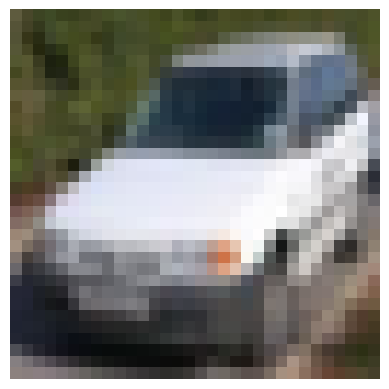

This is a b'automobile' 


In [174]:
img_no = random.randint(0, 10000)
img_no = 46

# Assuming `rbg_50k_img` is a PyTorch tensor of shape (50000, 3, 32, 32)
img = 255 * x_train[img_no]  # Select first image

# Convert from Tensor to NumPy for plotting
img = img.permute(1, 2, 0).numpy()  # Change shape from (3, 32, 32) -> (32, 32, 3)

# Display the image
plt.imshow(img.astype("uint8"))
plt.axis("off")  # Hide axis
plt.show()
print( f'This is a {label_map[int(y_train[img_no])]} ')

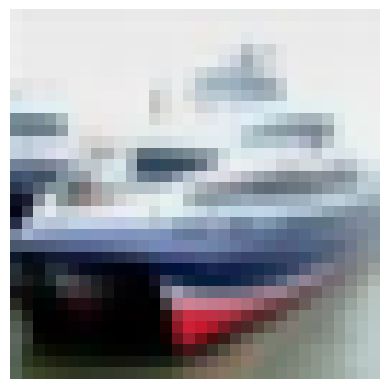

This is a b'ship' 


In [175]:
img_no = random.randint(0, 10000)
img_no = 1
# Assuming `rbg_50k_img` is a PyTorch tensor of shape (50000, 3, 32, 32)
img = 255**3 * x_test[img_no]  # Select first image

# Convert from Tensor to NumPy for plotting
img = img.permute(1, 2, 0).numpy()  # Change shape from (3, 32, 32) -> (32, 32, 3)

# Display the image
plt.imshow(img.astype("uint8"))
plt.axis("off")  # Hide axis
plt.show()
print( f'This is a {label_map[int(y_test[img_no])]} ')

In [176]:
torch.manual_seed(1)

class InterBlock(nn.Module):
    def __init__(self, device, num_convolutions, num_out_fc_layers, out_block = False):
        super(InterBlock, self).__init__() 
         
        self.device = device  
        self.num_out_fc_layers = num_out_fc_layers
        self.num_convolutions = num_convolutions
        self.num_channels = 3
        self.out_block = out_block
        
        self.LConvs = nn.ModuleList([
                            nn.Conv2d(in_channels=3, 
                                      out_channels= 11,
                                      kernel_size=3, 
                                      stride=1, 
                                      padding=1)  
                            for _ in range(num_convolutions)
                ]).to(self.device)
        self.FCL_a = nn.Linear(in_features= self.num_channels,
                               out_features= self.num_convolutions
                            ).to(self.device)
        self.FCL_out = nn.ModuleList([
                            nn.Linear(in_features=11 ,
                                      out_features=10) 
                                      for _ in range(num_out_fc_layers)
                            ]).to(self.device)

        self.compute_m = nn.AdaptiveAvgPool2d( (1,1) ).to(self.device)  ### Check that this is the same as the mean per channel
        self.Relu = nn.ReLU()   #OPTIONAL?!
    
    def compute_out(self, x):

        batch_size = x.shape[0]
        m = self.compute_m( x ).mean(dim =0 )
        m = m.reshape([1, m.shape[0]]) 
        print(f'OUTPUT LAYER m has shape {m.shape} and is inputted in the FCL')
        m = m.to(self.device)  # Move `m` to the correct device
        
        out = torch.zeros( [batch_size, 10], device=self.device)  # Ensure `out` is also on GPU if needed
        for dense in self.FCL_out:
            out += dense(m)

        return out / self.num_out_fc_layers  # Normalize output


    
    def forward(self, x):    
        x = x.to(device)
        batch_size = x.shape[0]

        # Computing a
        m = self.compute_m( x ).mean(dim =0 ).reshape([1, self.num_channels]) 
        print(f'm has shape {m.shape} and is inputted in the FCL')
        a = self.FCL_a(m).to(self.device)
        print(f'a has shape {a.shape} after the FCL')
             
             
        #Computing the convolutions
        conv_outputs = []
        for conv in self.LConvs:
            conv_outputs.append( self.Relu(conv(x)))  # each output has shape (batch_size, 11, 32, 32)
        # 2. Stack them into a single tensor of shape (batch_size, num_convs, 11, 32, 32)
        #    i.e. we insert a new dimension at dim=1 to hold the "num_convs" dimension.
        conv_outputs_stacked = torch.stack(conv_outputs, dim=1).to(self.device)
        # 3. Reshape 'a' to broadcast across the (11, 32, 32) dimensions.
        #    Now 'a' will have shape (batch_size, num_convs, 1, 1, 1).
        a = a.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).to(self.device)
        print(f'a has now has shape {a.shape}')
        
        # 4. Multiply and sum along the 'num_convs' dimension (dim=1).
        out = (conv_outputs_stacked * a).sum(dim=1)
        print(f"Weighted convolution output image x' has shape {out.shape}")
    
        if self.out_block:
            out = self.compute_out(out)
        
        out = self.Relu(out)

        return out  


device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

model = InterBlock( device, num_convolutions = 4, num_out_fc_layers=1, out_block= True ).to(device)
output = model.forward(x_train)

print(output.shape)

m has shape torch.Size([1, 3]) and is inputted in the FCL
a has shape torch.Size([1, 4]) after the FCL
a has now has shape torch.Size([1, 4, 1, 1, 1])
Weighted convolution output image x' has shape torch.Size([1000, 11, 32, 32])
OUTPUT LAYER m has shape torch.Size([1, 11]) and is inputted in the FCL
torch.Size([1000, 10])


In [177]:
class LeNet(torch.nn.Module):
    def __init__(self, num_outputs):
        super(LeNet, self).__init__()
        self.num_outputs = num_outputs

        self.Sigmoid = torch.nn.Sigmoid()

        self.Convl1 = torch.nn.Conv2d(3, 6, kernel_size=5, padding=2)
        self.Avg1 = torch.nn.AvgPool2d(2, stride=2)
        self.Convl2 = torch.nn.Conv2d(6, 16, kernel_size=5, padding=0)
        self.Avg2 = torch.nn.AvgPool2d(2, stride=2)

        self.Flatten = torch.nn.Flatten()
        self.Linear1 = torch.nn.Linear(576, 120)
        self.Linear2 = torch.nn.Linear(120, 84)
        self.Linear3 = torch.nn.Linear(84, self.num_outputs)

    def forward(self, x):
        out = self.Convl1(x)
        out = self.Sigmoid(out)
        out = self.Avg1(out)
        out = self.Convl2(out)
        out = self.Sigmoid(out)
        out = self.Avg2(out)
        out = self.Flatten(out)
        out = self.Linear1(out)
        out = self.Sigmoid(out)
        out = self.Linear2(out)
        out = self.Sigmoid(out)
        out = self.Linear3(out)
        return out

num_outputs = 10
model = LeNet(num_outputs)
model(x_train)

tensor([[ 0.0881,  0.1181, -0.2545,  ...,  0.3703, -0.0165, -0.1078],
        [ 0.0881,  0.1181, -0.2546,  ...,  0.3703, -0.0165, -0.1078],
        [ 0.0881,  0.1181, -0.2545,  ...,  0.3702, -0.0165, -0.1078],
        ...,
        [ 0.0881,  0.1181, -0.2545,  ...,  0.3702, -0.0165, -0.1078],
        [ 0.0881,  0.1181, -0.2545,  ...,  0.3703, -0.0165, -0.1078],
        [ 0.0881,  0.1180, -0.2546,  ...,  0.3703, -0.0164, -0.1078]],
       grad_fn=<AddmmBackward0>)

In [178]:
def evaluate_metric(model, data_iter, metric, device):
    """Compute the average `metric` of the model on a dataset.""" 
    c = torch.tensor(0.).to(device)
    n = torch.tensor(0.).to(device)
    model = model.to(device)
    
    for X, y in data_iter: 
        logits = model(X).to(device)
        c += metric(logits, y.to(device)).to(device)
        n += len(y)  
    return c / n


def correct(logits, y):
    y_hat = logits.argmax(axis=1).to(device) # Finds the column with the highest value for each row of `logits`.
    return (y_hat == y).float().sum() # Computes the number of times that `y_hat` and `y` match.

In [ ]:
batch_size = 256
train_iter, test_iter = load_data_cifar10(batch_size, resize=None, shuffle_train = True)

for x_train , y_train in train_iter:
    print("Batch X shape:", x_train.shape)
    print("Batch y shape:", y_train.shape)
    break

for x_test , y_test in test_iter:
    print("Batch X shape:", x_test.shape)
    print("Batch y shape:", y_test.shape)
    break


Files already downloaded and verified
Files already downloaded and verified
Batch X shape: torch.Size([256, 3, 32, 32])
Batch y shape: torch.Size([256])


In [ ]:
# Applies Xavier initialization if the `torch.nn.Module` is `torch.nn.Linear` or `torch.nn.Conv2d`
def init_weights(m):
    if type(m) == torch.nn.Linear or type(m) == torch.nn.Conv2d:
        torch.nn.init.xavier_uniform_(m.weight)


In [ ]:
num_outputs = 10

# model = LeNet(num_outputs)
model = InterBlock(device, num_convolutions=4, num_out_fc_layers=1).to(device)
model.apply(init_weights) # Applies `init_weights` to every `torch.nn.Module` inside `model`

losses = [] # Stores the loss for each training batch
train_accs = [] # Stores the training accuracy after each epoch
test_accs = [] # Stores the testing accuracy after each epoch

cross_entropy_loss = torch.nn.CrossEntropyLoss()
lr = 0.9
optimizer = torch.optim.SGD(model.parameters(), lr=lr)  

num_epochs = 20
x = torch.tensor(3)
iters = 0
for epoch in range(num_epochs):
    print(f'\nEpoch {epoch + 1}/{num_epochs}.')
    
    print(f'{iters} iterations')
    iters = 0
    for x_train, y_train in train_iter: 
        iters += 1
        # print(x.shape , x_train.shape)
        x = x_train
        logits = model(x_train).to(device) 
        
        l = cross_entropy_loss(logits , y_train.to(device)).to(device) # Computes the loss given the `logits` and the class vector `y`
        optimizer.zero_grad() # Zeroes the gradients stored in the model parameters
        l.backward() # Computes the gradient of the loss `l` with respect to the model parameters

        optimizer.step() # Updates the model parameters based on the gradients stored inside them
        
        losses.append(float(l)) # Stores the loss for this batch
       
    with torch.no_grad(): # Computing performance metrics does not require gradients
        train_accs.append( evaluate_metric(model, train_iter , correct, device)  ) 
        test_accs.append( evaluate_metric(model, test_iter, correct, device) ) 
        print(f'Training accuracy: {train_accs[-1]}. Testing accuracy: {test_accs[-1]}.')


Epoch 1/20.
0 iterations
a has shape torch.Size([256, 3]) before the FCL
a has shape torch.Size([256, 4]) after the FCL
a has now has shape torch.Size([256, 4, 1, 1, 1])
a has shape torch.Size([256, 3]) before the FCL
a has shape torch.Size([256, 4]) after the FCL
a has now has shape torch.Size([256, 4, 1, 1, 1])
a has shape torch.Size([256, 3]) before the FCL
a has shape torch.Size([256, 4]) after the FCL
a has now has shape torch.Size([256, 4, 1, 1, 1])
a has shape torch.Size([256, 3]) before the FCL
a has shape torch.Size([256, 4]) after the FCL
a has now has shape torch.Size([256, 4, 1, 1, 1])
a has shape torch.Size([256, 3]) before the FCL
a has shape torch.Size([256, 4]) after the FCL
a has now has shape torch.Size([256, 4, 1, 1, 1])
a has shape torch.Size([256, 3]) before the FCL
a has shape torch.Size([256, 4]) after the FCL
a has now has shape torch.Size([256, 4, 1, 1, 1])
a has shape torch.Size([256, 3]) before the FCL
a has shape torch.Size([256, 4]) after the FCL
a has now

In [ ]:
print(x.shape , x_train.shape)

torch.Size([80, 3, 32, 32]) torch.Size([80, 3, 32, 32])


In [ ]:
x.shape , x_train.shape

(torch.Size([80, 3, 32, 32]), torch.Size([80, 3, 32, 32]))

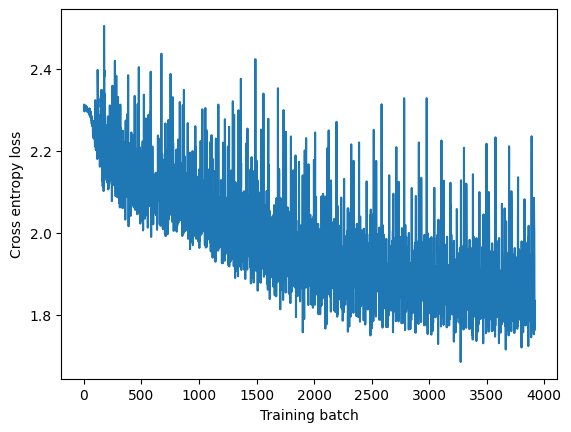

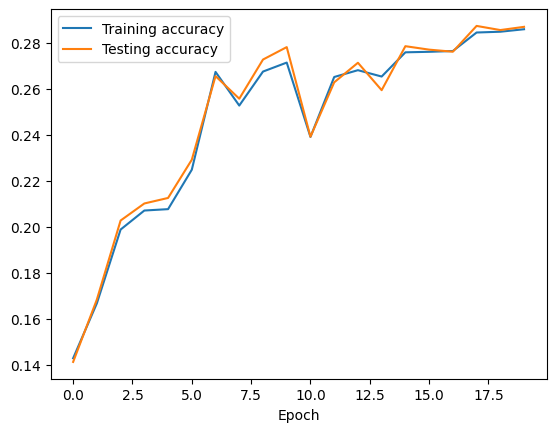

In [ ]:
plt.plot(losses) # Plots the loss for each training batch
plt.xlabel('Training batch')
plt.ylabel('Cross entropy loss')
plt.show()

plt.plot(train_accs, label='Training accuracy')
plt.plot(test_accs, label='Testing accuracy')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.show()